In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from segmentation.helper_functions.general_functions import extract_image_names_from_folder
from segmentation.data_handling.dataloaders import BasicDataset
from segmentation.data_handling import prep_dataloader
import os
from os.path import join
from tqdm.notebook import tqdm

training_data = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/data/processed_gels/big_set/Training_Set'
t_images, t_masks = join(training_data, 'Images'), join(training_data, 'Masks')

val_data = '/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/data/processed_gels/big_set/Validation_Set'
v_images, v_masks = join(val_data, 'Images'), join(val_data, 'Masks')

all_t_images = extract_image_names_from_folder(t_images)
# v_images = extract_image_names_from_folder(v_images)
# t_masks = extract_image_names_from_folder(t_masks)
# v_masks = extract_image_names_from_folder(v_masks)

t_data, v_data, _, _ = prep_dataloader(t_images, t_masks, False, v_images, v_masks, 1, 1, 0, 1, 1, False, True)

In [15]:
# not worth doing - too slow
train_images = np.zeros((99, 1376, 1376))
train_masks = np.zeros((99, 1376, 1376))

for index, batch in enumerate(tqdm(t_data)):
    train_images[index, :] = batch['image'].numpy()
    train_masks[index, :] = batch['mask'].numpy()

  0%|          | 0/99 [00:00<?, ?it/s]

/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_20366/2748584418.py:39: FutureWarning: `multichannel` is a deprecated argument name for `multiscale_basic_features`. It will be removed in version 1.0. Please use `channel_axis` instead.
  full_feat = features_func(im).reshape(-1,15)


fitting...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_20366/2748584418.py:68: FutureWarning: `multichannel` is a deprecated argument name for `multiscale_basic_features`. It will be removed in version 1.0. Please use `channel_axis` instead.
  f_retest = features_func(image_combo[-1]).reshape(-1,15)
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    1.0s finished
/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_20366/2748584418.py:83: FutureWarning: `multichannel` is a deprecated argument name for `multiscale_basic_features`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = featur

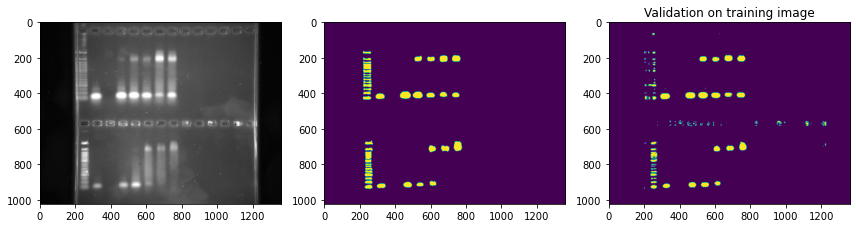

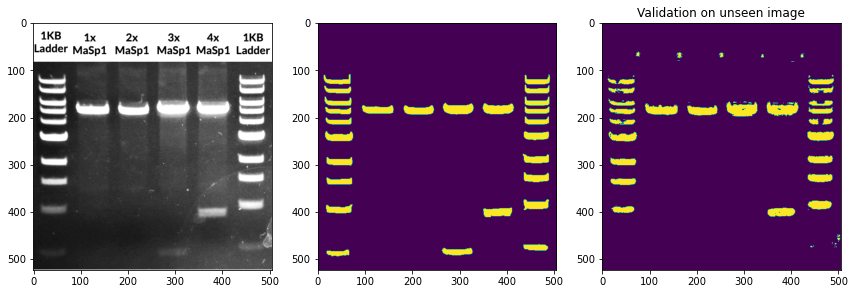

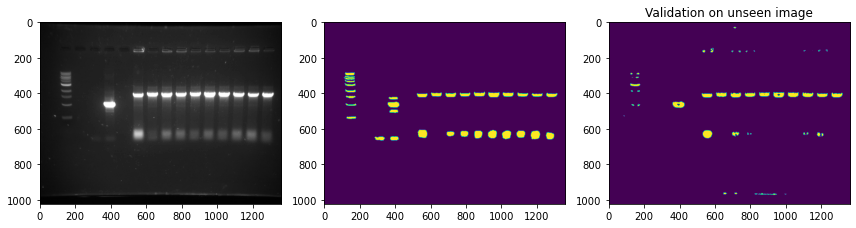

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skimage.io import imread
from skimage.color import rgb2gray

sigma_min = 1
sigma_max = 16
features_func = partial(
    feature.multiscale_basic_features,
    intensity=True,
    edges=False,
    texture=True,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    multichannel=False,
)

def read_im_and_mask(name):
    image = imread(join(t_images, name))
    
    if len(image.shape) == 3:
        if image.shape[-1] == 4:
            image = rgb2gray(image[:,:,0:3])
        else:
            image = rgb2gray(image)

    im_shape = image.shape

    mask = imread(join(t_masks, name.split('.')[0]) + '.tif')
    return image, im_shape, mask

def combine_im_features_masks(images, masks):
    
    feat_list = []
    mask_list = []

    for im, ms in zip(image_combo, mask_combo):
        # obtain features from image
        full_feat = features_func(im).reshape(-1,15)
        mravel = ms.ravel()
#         feat_list.append(full_feat[mravel>0,:])
#         mask_list.append(mravel[mravel>0])
        
        feat_list.append(full_feat)
        mask_list.append(mravel)
    
    return np.vstack(feat_list), np.hstack(mask_list)

image_combo = []
im_shape_combo = []
mask_combo = []
for name in all_t_images[0:20]:  # 20-30 is limit, any higher and will require too much memory
    name = name.split('/')[-1]
    image, im_shape, mask = read_im_and_mask(name)
    image_combo.append(image)
    mask_combo.append(mask)
    im_shape_combo.append(im_shape)

features, training_labels = combine_im_features_masks(image_combo, mask_combo)

clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05, verbose=True)

print('fitting...')
clf.fit(features, training_labels)


f_retest = features_func(image_combo[-1]).reshape(-1,15)

pred_image = clf.predict(f_retest).reshape(im_shape_combo[-1])

# plot results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(image_combo[-1],cmap='gray')
ax[1].imshow(mask_combo[-1])
ax[2].imshow(pred_image)
plt.title('Validation on training image')
fig.tight_layout()

##############
image, im_shape, mask = read_im_and_mask('Ivan-gels .png')

features = features_func(image).reshape(-1,15)
pred_image = clf.predict(features).reshape(im_shape)  # here, each pixel is assumed as a separate 'datapoint' to predict.  This results in enormous memory requirements.

# plot results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(image,cmap='gray')
ax[1].imshow(mask)
ax[2].imshow(pred_image)
plt.title('Validation on unseen image')
fig.tight_layout()

image, im_shape, mask = read_im_and_mask('UVP02234July42019.jpg')

features = features_func(image).reshape(-1,15)
pred_image = clf.predict(features).reshape(im_shape)

# plot results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(image,cmap='gray')
ax[1].imshow(mask)
ax[2].imshow(pred_image)
plt.title('Validation on unseen image')
fig.tight_layout()

/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_20366/2269300214.py:9: FutureWarning: `multichannel` is a deprecated argument name for `multiscale_basic_features`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = features_func(image).reshape(-1,15)
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    1.0s finished


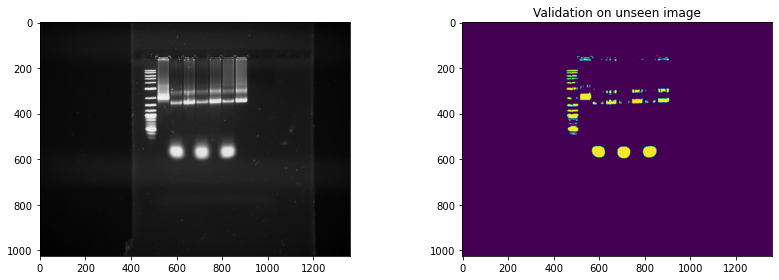

In [9]:
# TESTING
image = imread('/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/scratch_data/DL_scratch/2_origami.tif')
im_shape = image.shape
if len(image.shape) == 3:
    if image.shape[-1] == 4:
        image = rgb2gray(image[:,:,0:3])
    else:
        image = rgb2gray(image)

features = features_func(image).reshape(-1,15)

pred_image = clf.predict(features).reshape(im_shape)

# plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(image,cmap='gray')
ax[1].imshow(pred_image)
plt.title('Validation on unseen image')
fig.tight_layout()